In [ ]:
#upload CSV file:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['data_new_with_quality_scores.csv']))

# Quick check
print(df.shape)
df.head()


Saving data_new_with_quality_scores.csv to data_new_with_quality_scores.csv
(14731, 23)


,projectID,status,startDate,endDate,totalCost,ecMaxContribution,OQI_month_norm,country,region,region_code,...,sub_fund_code,organizationCount,countryCount,europeanCountryCount,countryDiversityIndex,europeanOrganizationRatio,geoCentralizationIndex(KM),crossSectorCollaborationIndex,fundingEqualityIndex,quality_score_scaled
0,101116741,SIGNED,2024-02-01,2029-01-31,1499998,1499998,0.000000,NL,Western Europe,1,...,1,1,1,1,0.0000,1.00,0.00,0.0000,1.0000,0.000000
1,101162875,SIGNED,2025-03-01,2030-02-28,1500000,1500000,0.000000,IT,Southern Europe,3,...,1,2,2,2,0.6931,1.00,708.10,0.0000,0.5333,0.000000
2,101167314,SIGNED,2025-04-01,2031-03-31,11982258,11982258,0.000000,IT,Southern Europe,3,...,1,4,4,3,1.3863,0.75,2646.68,0.5623,0.9696,0.000000
3,101072693,SIGNED,2022-08-01,2024-07-31,100000,100000,0.021259,UA,Eastern Europe,4,...,4,1,1,0,0.0000,0.00,0.00,0.0000,1.0000,0.270017
4,101172406,SIGNED,2024-07-01,2025-12-31,608440,300000,0.000000,PL,Eastern Europe,4,...,4,1,1,1,0.0000,1.00,0.00,0.0000,1.0000,0.000000


In [ ]:
# Cell 2: Data preprocessing and feature transformation

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

# 1. Define features to transform
log_vars = ['totalCost', 'ecMaxContribution']
scale_only_vars = [
    'europeanOrganizationRatio',
    'geoCentralizationIndex(KM)',
    'organizationCount',
    'countryCount'
]
categorical_vars = ['region_code', 'topic_code', 'sub_fund_code']

# 2. Build individual pipelines
log_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('standard_scaler', StandardScaler())
])
scale_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])
cat_pipeline = OneHotEncoder(handle_unknown='ignore')

# 3. Combine pipelines into a single transformer
preprocessor = ColumnTransformer([
    ('log_features',        log_pipeline,    log_vars),
    ('scaled_features',     scale_pipeline,  scale_only_vars),
    ('categorical_features', cat_pipeline,    categorical_vars),
], remainder='drop')

# 4. Fit and transform the DataFrame
X_processed = preprocessor.fit_transform(df)

# 5. Verify the output shape
print(f"Shape of processed features: {X_processed.shape}")


Shape of processed features: (14731, 28)


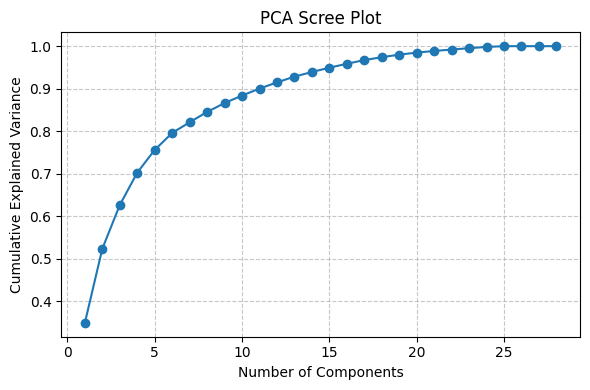

     PC  ExplainedVariance  CumulativeVariance
0   PC1           0.348896            0.348896
1   PC2           0.174455            0.523351
2   PC3           0.102893            0.626243
3   PC4           0.076142            0.702385
4   PC5           0.053589            0.755974
5   PC6           0.039781            0.795756
6   PC7           0.025261            0.821017
7   PC8           0.024191            0.845208
8   PC9           0.020968            0.866177
9  PC10           0.017651            0.883828


In [ ]:
# Cell 3: PCA and Scree Plot

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1. Fit PCA on the preprocessed features
pca = PCA()
X_pca = pca.fit_transform(X_processed)

# 2. Compute explained variance ratios
explained_variance = pca.explained_variance_ratio_
cum_var = explained_variance.cumsum()

# 3. Plot cumulative explained variance (scree plot)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Display explained variance for the first 10 components
df_var = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_variance))],
    'ExplainedVariance': explained_variance,
    'CumulativeVariance': cum_var
})
print(df_var.head(10))


In [ ]:
# Cell 4: Examine Principal Component Loadings

# 1. Choose number of components to inspect
n_components = 6

# 2. Re-fit PCA with fixed n_components and transform
pca6 = PCA(n_components=n_components)
X_pca6 = pca6.fit_transform(X_processed)

# 3. Build feature name list
num_feats = log_vars + scale_only_vars
cat_feats = preprocessor.named_transformers_['categorical_features']\
    .get_feature_names_out(categorical_vars).tolist()
all_features = num_feats + cat_feats

# 4. Create a DataFrame of loadings
loadings = pd.DataFrame(
    pca6.components_.T,
    index=all_features,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# 5. Print top 5 positive and negative loadings for PC1 and PC2
for pc in ['PC1', 'PC2']:
    print(f"\n>>> {pc} Top 5 Positive Loadings:")
    print(loadings[pc].nlargest(5))
    print(f"\n>>> {pc} Top 5 Negative Loadings:")
    print(loadings[pc].nsmallest(5))



>>> PC1 Top 5 Positive Loadings:
countryCount                  0.546164
organizationCount             0.520787
ecMaxContribution             0.409176
geoCentralizationIndex(KM)    0.323572
totalCost                     0.290639
Name: PC1, dtype: float64

>>> PC1 Top 5 Negative Loadings:
sub_fund_code_1             -0.187010
topic_code_2                -0.052833
topic_code_3                -0.040938
europeanOrganizationRatio   -0.036277
region_code_1               -0.031762
Name: PC1, dtype: float64

>>> PC2 Top 5 Positive Loadings:
europeanOrganizationRatio    0.727168
totalCost                    0.289033
ecMaxContribution            0.145473
region_code_1                0.104117
organizationCount            0.070222
Name: PC2, dtype: float64

>>> PC2 Top 5 Negative Loadings:
geoCentralizationIndex(KM)   -0.564036
region_code_6                -0.139072
sub_fund_code_1              -0.083761
topic_code_1                 -0.018476
topic_code_4                 -0.013038
Name: PC2, dtype

In [ ]:
# Cell 5: Determine and extract optimal number of principal components

from sklearn.decomposition import PCA
import numpy as np

# 1. Fit a full PCA to get explained variance ratios
pca_full = PCA()
pca_full.fit(X_processed)
explained_variance = pca_full.explained_variance_ratio_
cum_var = explained_variance.cumsum()

# 2. Find how many components explain ≥80% of the variance
threshold = 0.80
n_components_opt = np.argmax(cum_var >= threshold) + 1
print(f"Components needed for ≥{int(threshold*100)}% variance: {n_components_opt}")

# 3. Re-fit PCA using that many components and transform the data
pca_opt = PCA(n_components=n_components_opt)
X_pca_opt = pca_opt.fit_transform(X_processed)
print(f"Shape of X_pca_opt with {n_components_opt} components: {X_pca_opt.shape}")


Components needed for ≥80% variance: 7
Shape of X_pca_opt with 7 components: (14731, 7)


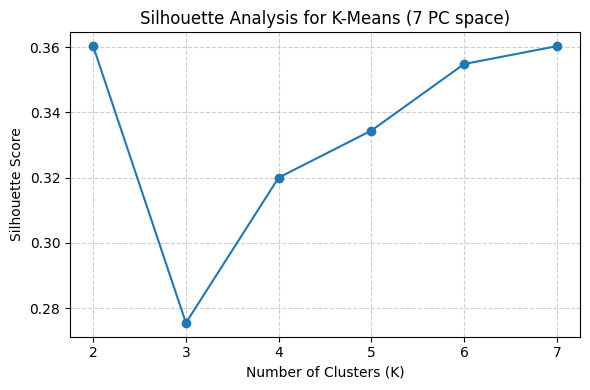

Optimal number of clusters: K = 7
cluster
0    2643
1    4498
2    3607
3    1807
4     354
5    1015
6     807
Name: count, dtype: int64


In [ ]:
# Cell 6: K-Means clustering

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Recompute PCA with the chosen number of components (e.g., 7)
n_components_opt = 7
pca_opt = PCA(n_components=n_components_opt)
X_pca_opt = pca_opt.fit_transform(X_processed)

# 2. Compute silhouette scores for K = 2…7
sil_scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca_opt)
    sil_scores[k] = silhouette_score(X_pca_opt, labels)

# 3. Plot silhouette versus K
plt.figure(figsize=(6,4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-Means (7 PC space)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Fit final KMeans with the optimal K
best_k = max(sil_scores, key=sil_scores.get)
print(f"Optimal number of clusters: K = {best_k}")

km_opt = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = km_opt.fit_predict(X_pca_opt)

# 5. Display cluster counts
print(df['cluster'].value_counts().sort_index())


Cluster centroids in PCA space:
              PC1       PC2       PC3       PC4       PC5       PC6       PC7
cluster                                                                      
0       -1.088905  0.142501 -0.926905  0.699756 -0.256817  0.002919  0.074641
1       -0.824400  0.583517  0.756527 -0.147497  0.223038  0.042921  0.110467
2        2.277043  0.468707  0.313601  0.006100  0.049047 -0.063668 -0.040503
3       -1.744082 -0.099481 -0.697031 -0.780098  0.047921 -0.097449 -0.271116
4       -1.097057 -3.580705  2.437538 -0.032232 -2.755331 -0.250522 -0.176061
5        1.296259 -0.282204 -1.581817 -0.042573 -0.362143  0.127743 -0.111611
6        0.743672 -3.665752 -0.102180  0.317717  0.935346  0.203080  0.145358

Cluster profiles (mean of original features):
            totalCost  ecMaxContribution  europeanOrganizationRatio  \
cluster                                                               
0        0.000000e+00       2.484823e+07                      0.998   
1     

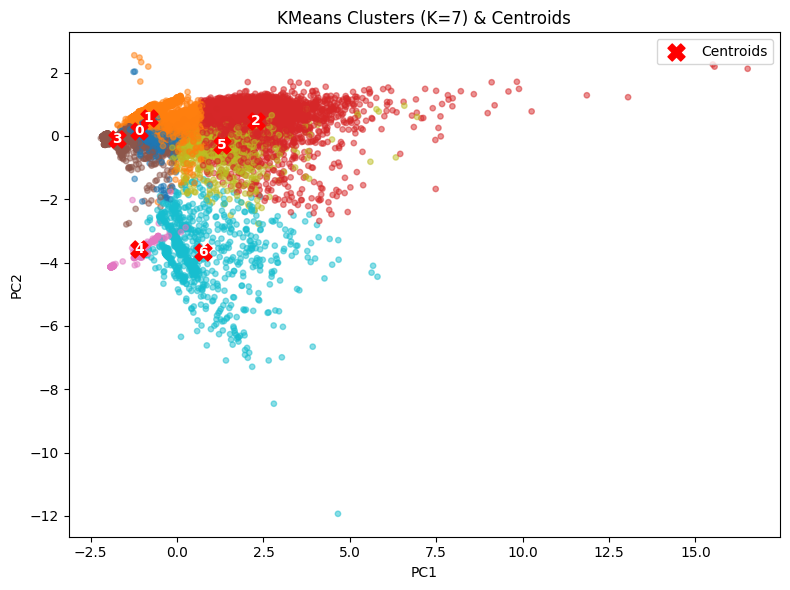

In [ ]:
# Cell 7: Profile clusters

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



# 1. Refit KMeans
km = KMeans(n_clusters=best_k, random_state=42).fit(X_pca_opt)

# 2. Compute PCA-space centroids
centroids = pd.DataFrame(
    km.cluster_centers_,
    columns=[f"PC{i+1}" for i in range(X_pca_opt.shape[1])]
)
centroids.index.name = 'cluster'
print("Cluster centroids in PCA space:")
print(centroids)

# 3. Compute mean values of original numeric features for each cluster
features_to_profile = log_vars + scale_only_vars
cluster_profile = df.groupby('cluster')[features_to_profile].mean().round(3)
print("\nCluster profiles (mean of original features):")
print(cluster_profile)

# 4. Visualize clusters on PC1 vs PC2 with centroids
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca_opt[:,0],
    X_pca_opt[:,1],
    c=km.labels_,
    cmap='tab10',
    s=15,
    alpha=0.5
)
plt.scatter(
    centroids['PC1'],
    centroids['PC2'],
    c='red',
    s=150,
    marker='X',
    label='Centroids'
)
for idx, (x, y) in centroids[['PC1','PC2']].iterrows():
    plt.text(x, y, str(idx), color='white', weight='bold',
             ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'KMeans Clusters (K={best_k}) & Centroids')
plt.legend()
plt.tight_layout()
plt.show()


Cluster Quality Summary:
         count  mean_OQI  median_OQI  pct_nonzero
cluster                                          
2         3607    0.0177      0.0060      59.2736
6          807    0.0067      0.0006      51.0533
5         1015    0.0053      0.0000      26.2069
0         2643    0.0048      0.0009      50.6243
1         4498    0.0045      0.0000      37.8390
3         1807    0.0043      0.0000      39.9557
4          354    0.0018      0.0000      30.2260


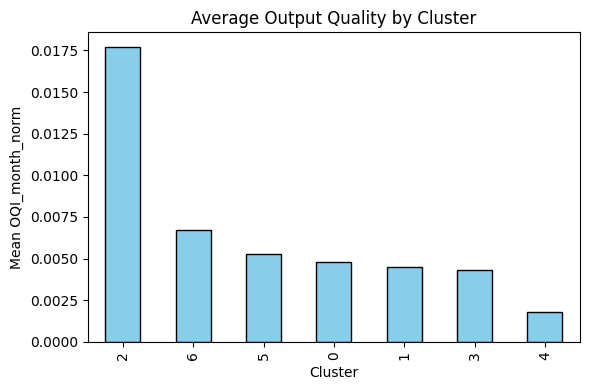

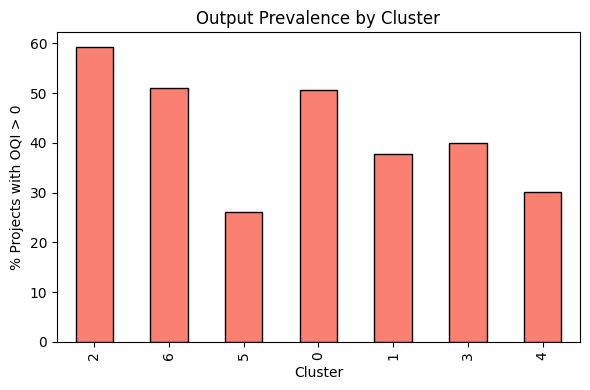

In [ ]:
# Cell 8: Evaluate actual output quality (OQI_month_norm) per cluster

import pandas as pd
import matplotlib.pyplot as plt

# 1. Aggregate by cluster: count, mean, median, % non-zero
cluster_quality = df.groupby('cluster')['OQI_month_norm'].agg(
    count='size',
    mean_OQI='mean',
    median_OQI='median',
    pct_nonzero=lambda x: (x.gt(0).sum() / x.size) * 100
).sort_values('mean_OQI', ascending=False).round(4)

print("Cluster Quality Summary:")
print(cluster_quality)

# 2. Bar plot of mean OQI by cluster
plt.figure(figsize=(6,4))
cluster_quality['mean_OQI'].plot(
    kind='bar',
    color='skyblue',
    edgecolor='k'
)
plt.xlabel('Cluster')
plt.ylabel('Mean OQI_month_norm')
plt.title('Average Output Quality by Cluster')
plt.tight_layout()
plt.show()

# 3. Bar plot of % projects with any output
plt.figure(figsize=(6,4))
cluster_quality['pct_nonzero'].plot(
    kind='bar',
    color='salmon',
    edgecolor='k'
)
plt.xlabel('Cluster')
plt.ylabel('% Projects with OQI > 0')
plt.title('Output Prevalence by Cluster')
plt.tight_layout()
plt.show()


Top 5 metadata contributors for cluster 2:
totalCost                     4.043643e+08
ecMaxContribution             2.533689e+08
geoCentralizationIndex(KM)    4.827372e+02
organizationCount             1.002637e+01
countryCount                  4.775302e+00
dtype: float64


<Figure size 600x400 with 0 Axes>

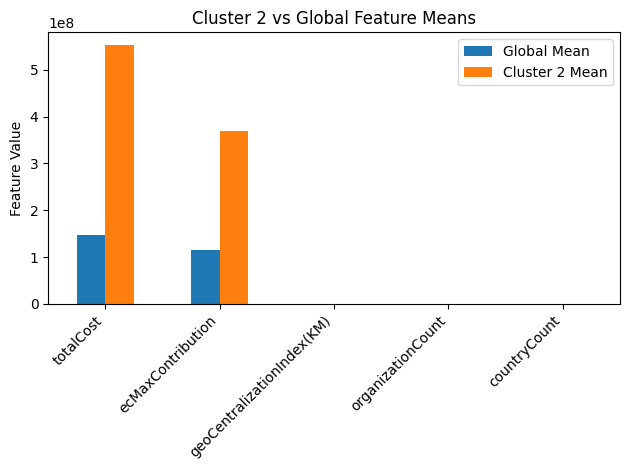

In [ ]:
# Cell 9: Identify key metadata drivers for a given cluster

import pandas as pd
import matplotlib.pyplot as plt

# 2. Define the metadata features to inspect
features = [
    'totalCost',
    'ecMaxContribution',
    'europeanOrganizationRatio',
    'geoCentralizationIndex(KM)',
    'organizationCount',
    'countryCount'
]

# 3. Compute global means
global_means = df[features].mean()

# 4. Compute cluster‐specific means (e.g., for cluster 2)
cluster_id = 2
cluster_means = df[df['cluster'] == cluster_id][features].mean()

# 5. Compute absolute differences and sort
diff = (cluster_means - global_means).abs().sort_values(ascending=False)

# 6. Display top 5 metadata variables driving cluster 2
top5 = diff.head(5)
print(f"Top 5 metadata contributors for cluster {cluster_id}:")
print(top5)

# 7. Bar plot of cluster vs global for these top features
plt.figure(figsize=(6,4))
df_plot = pd.DataFrame({
    'Global Mean': global_means[top5.index],
    f'Cluster {cluster_id} Mean': cluster_means[top5.index]
})
df_plot.plot(kind='bar')
plt.ylabel('Feature Value')
plt.title(f'Cluster {cluster_id} vs Global Feature Means')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
